# TEAM HU-EXTERNALS , Week7: Time Series Analysis

## goals

Using Berlin COVID-19 data, we want to predict 10 days of cases.

We want to use ARIMA, facebook prophet and XGBoost.

# Data preparation

First, lets get the realworld data form this git repo https://github.com/jgehrcke/covid-19-germany-gae

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

url = 'https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/data.csv'
df = pd.read_csv(url, error_bad_lines=False, index_col=["time_iso8601"],
    parse_dates=["time_iso8601"],
    date_parser=lambda col: pd.to_datetime(col, utc=True))
df.index.name = "time"
df.head()

source  DE-BW_cases  ...  sum_cases  sum_deaths
time                                             ...                       
2020-03-10 11:00:00+00:00  RKI PDF          237  ...       1296           0
2020-03-11 11:00:00+00:00  RKI PDF          277  ...       1567           0
2020-03-12 11:00:00+00:00  RKI PDF          454  ...       2369           0
2020-03-13 11:00:00+00:00  RKI PDF          454  ...       3062           0
2020-03-14 11:00:00+00:00  RKI PDF          569  ...       3795           0

[5 rows x 35 columns]

Now, lets only take the Berlin cases 

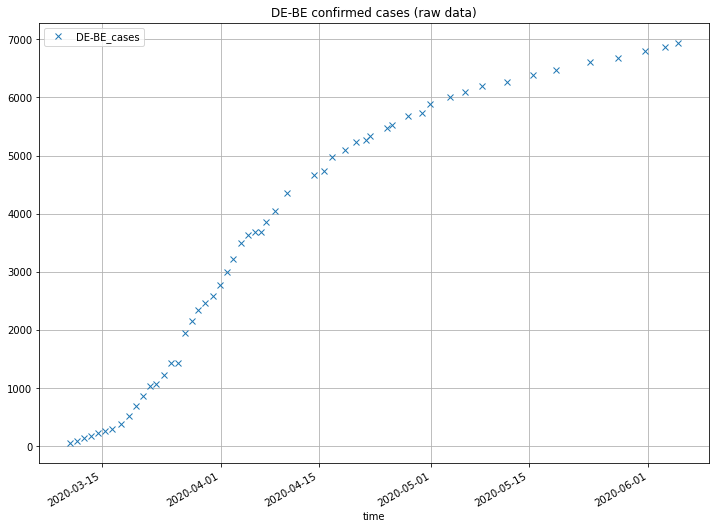

In [0]:
df = df[['DE-BE_cases']]
df.plot(title="DE-BE confirmed cases (raw data)", style='x', grid=True, figsize=[12, 9])

And now cut the data to a training and a testing set 

In [0]:
data = df.loc['2020-03-01 00:00:00+00:00':'2020-04-20 23:59:00+00:00']
testing = df.loc['2020-04-21 00:00:00+00:00':'2020-04-30 23:59:00+00:00']

At this point, we have a real-world problem: the time series is unevenly-spaced. 
First, in order to get a constant lag between datapoints, we will naively resample the data by taking the mean case count per day, and interpulate the missing data

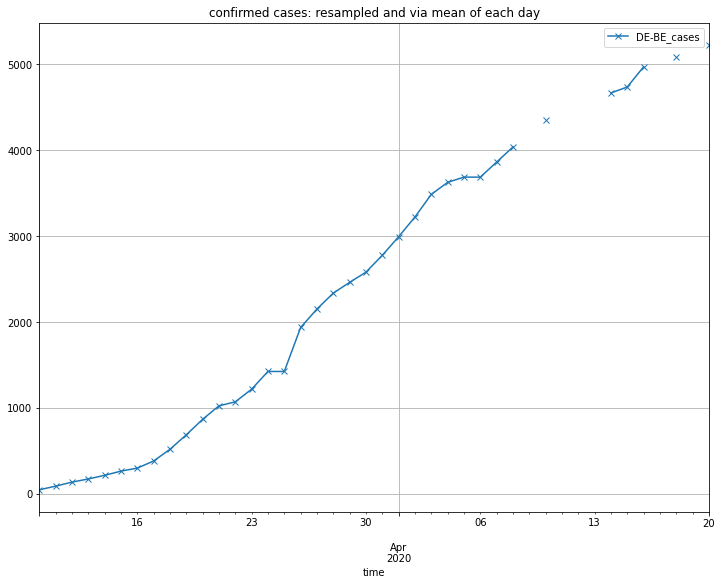

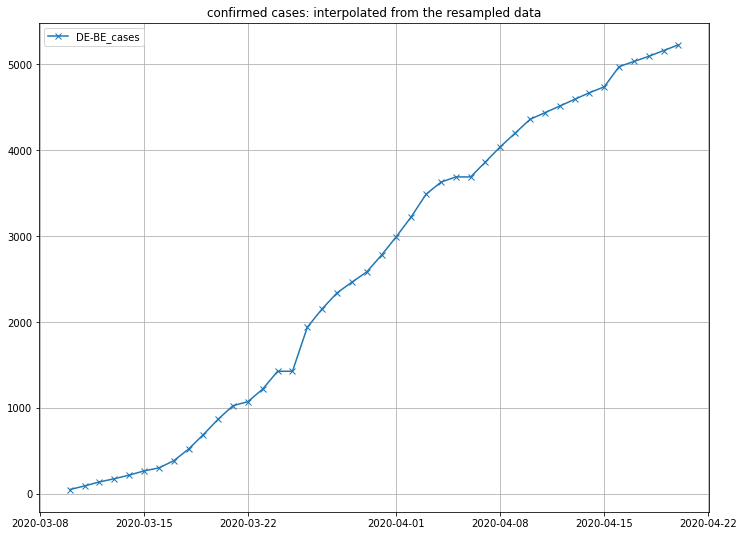

In [0]:
reampled_df = data.resample('D').mean()
reampled_df.plot(title="confirmed cases: resampled and via mean of each day", marker="x", grid=True, figsize=[12, 9])
interpolated_df = reampled_df.interpolate(method='time')
interpolated_df.index = interpolated_df.index.normalize().date
interpolated_df.plot(title="confirmed cases: interpolated from the resampled data", marker="x", grid=True, figsize=[12, 9])

Note: while generally this graph looks quite fine, we have definitely oversampled areas that we interpulated (aliasing), which is a bad idea if we want to use this data for predictive perpuses. 

## 10-day preduction via a “classical” time-series prediction approach: ARIMA

In [0]:
#install pyramid arima
!pip install pyramid-arima
!pip install pmdarima

     |████████████████████████████████| 604kB 4.6MB/s 
     |████████████████████████████████| 1.5MB 4.8MB/s 
     |████████████████████████████████| 8.7MB 25.8MB/s 
     |████████████████████████████████| 2.1MB 46.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.19
    Uninstalling Cython-0.29.19:
      Successfully uninstalled Cython-0.29.19


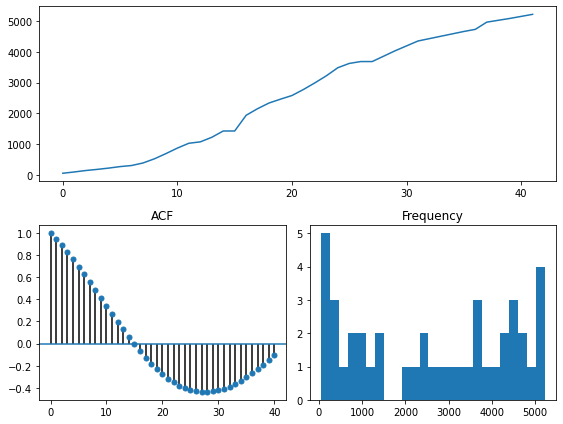

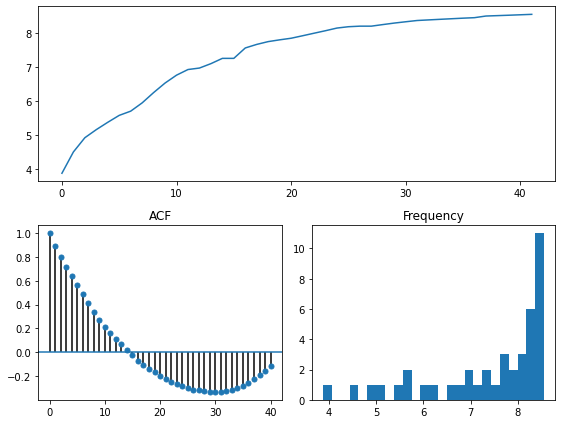

residual stationarity:


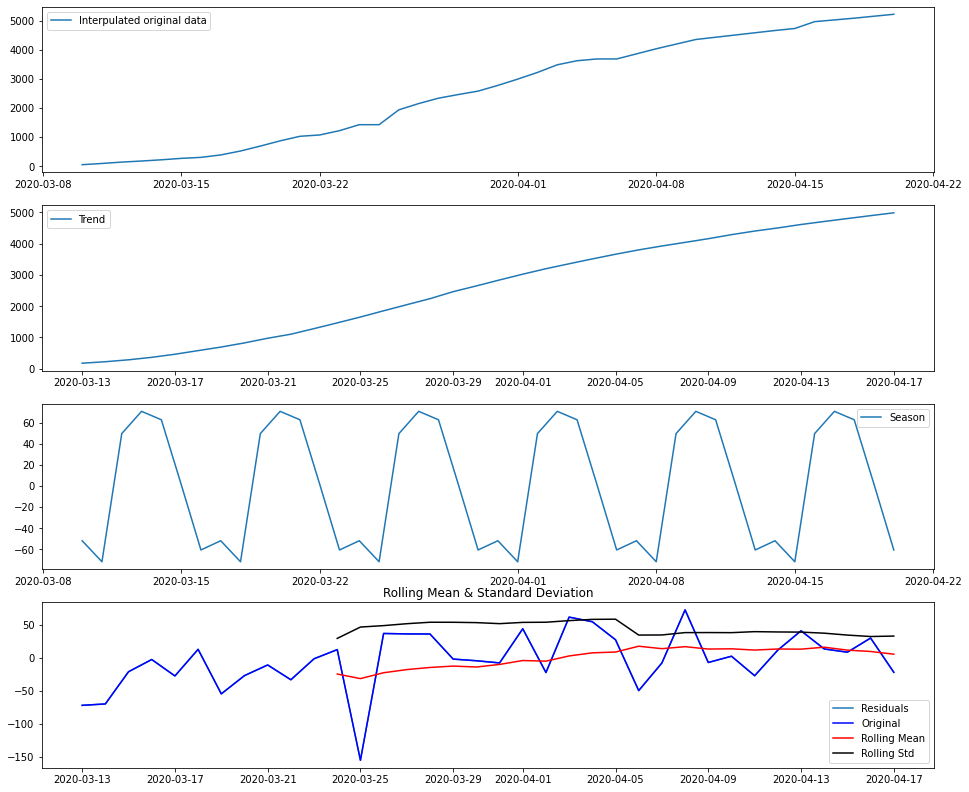

Results of Dickey-Fuller Test:
Test Statistic                -5.686510e+00
p-value                        8.255670e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.500000e+01
Critical Value (1%)           -3.632743e+00
Critical Value (5%)           -2.948510e+00
Critical Value (10%)          -2.613017e+00
dtype: float64
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=434.616, BIC=443.948, Fit time=0.665 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=435.565, BIC=438.676, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=437.214, BIC=443.436, Fit time=0.212 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=435.186, BIC=441.408, Fit time=0.173 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=434.106, BIC=441.883, Fit time=0.461 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=439.167, BIC=445.388, Fit time=0.111 seconds
Fit ARIMA: order

In [0]:
# taken form https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/ , https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
def test_stationarity(timeseries):
    #df to series
    if isinstance(timeseries, pd.DataFrame): 
        timeseries = timeseries.squeeze()
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
# check out log transformation to see if it helps -> does not.
from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import LogEndogTransformer

tsdisplay(interpolated_df,lag_max=40)
y_train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(interpolated_df)
tsdisplay(y_train_log, lag_max=40)

# decompose the data to season+trend+resi, test, and visualize it 
interpolated_df.index = pd.to_datetime(interpolated_df.index)
decomp = seasonal_decompose(interpolated_df)

trend = decomp.trend
season = decomp.seasonal
residuals = decomp.resid

decomp_fig = plt.figure(figsize=(16,14))
ax1 = decomp_fig.add_subplot(411)
ax1.plot(interpolated_df, label='Interpulated original data')
ax1.legend()
ax2 = decomp_fig.add_subplot(412)
ax2.plot(trend, label='Trend')
ax2.legend()
ax3 = decomp_fig.add_subplot(413)
ax3.plot(season, label='Season')
ax3.legend()
ax4 = decomp_fig.add_subplot(414)
ax4.plot(residuals, label='Residuals')
ax4.legend()

data_log_resi = residuals
data_log_resi.dropna(inplace=True)
print('residual stationarity:')
test_stationarity(data_log_resi)

# fit model and predict - with log scaled data  -> bad
#print('log scaled data stationarity:')
#test_stationarity(log_scaled_data)
#model = ARIMA(log_scaled_data, order=(2, 1, 2),freq='D')
#model_fit = model.fit(disp=False)
#yhat_log = model_fit.predict(1, len(log_scaled_data)+10, typ='levels')
#yhat = np.exp(yhat_log)

# fit model and predict with auto-optimized ARIMA/SRIMAX (https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c)
from pyramid.arima import auto_arima
stepwise_model = auto_arima(interpolated_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=6,
                           start_P=1, seasonal=True,
                           d=1,D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
stepwise_model.fit(interpolated_df)
future_forecast = stepwise_model.predict(n_periods=10,return_conf_int=True)
future_dates = pd.date_range(start=interpolated_df.index[-1]+pd.DateOffset(1), periods=10)
yhat = pd.Series(future_forecast[0], index=future_dates)
conf_int_upper = pd.Series(future_forecast[1][:,1], index=future_dates)
conf_int_lower= pd.Series(future_forecast[1][:,0], index=future_dates)
print(yhat)
print(conf_int_upper)
# plot prediction
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(interpolated_df,color='black',label='original_data (training)')
ax.plot(yhat,color='blue',label='ARIMA prediction')
ax.fill_between(yhat.index, conf_int_lower.values, conf_int_upper.values, color='b', alpha=.1)
ax.plot(testing,'x',color='red',label='testing data')

ax.grid()
ax.legend()

In [0]:
# calc RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
forcast_comparison_df = yhat.to_frame(name="yhat")
testing_comparison_df = testing.copy()
testing_comparison_df.index = testing_comparison_df.index.normalize().date
merged_comparison_df = forcast_comparison_df.merge(testing_comparison_df,left_index=True,right_index=True)
RMSE = sqrt(mean_squared_error(merged_comparison_df['DE-BE_cases'], merged_comparison_df['yhat']))
print('RMSE: ', RMSE)


RMSE:  166.08592929987574


## 10-day preduction via Prophet

In [0]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
prophet_data = pd.DataFrame({'ds': data.index.values, 'y': data['DE-BE_cases'].values})

## vanilla Prophet:
m = Prophet()
## logistic growth Prophet, with cap at 70% of berlin population
#prophet_data['cap'] = 2.63*10**6
#m = Prophet(growth='logistic')
## modified version (https://mc.ai/time-series-forecasting-for-covid-19/):
#m = Prophet(growth ='linear',
#seasonality_mode='multiplicative',
#changepoint_prior_scale=0.5,
#weekly_seasonality=False,
#daily_seasonality=True)
m.fit(prophet_data)
future = m.make_future_dataframe(periods=10)
# if logistic growth, enable the next line
#future['cap'] = 2.63*10**6
forecast = m.predict(future)
fig1 = m.plot(forecast, plot_cap=False)
fig2 = m.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
print(forecast.info())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          46 non-null     datetime64[ns]
 1   trend                       46 non-null     float64       
 2   yhat_lower                  46 non-null     float64       
 3   yhat_upper                  46 non-null     float64       
 4   trend_lower                 46 non-null     float64       
 5   trend_upper                 46 non-null     float64       
 6   additive_terms              46 non-null     float64       
 7   additive_terms_lower        46 non-null     float64       
 8   additive_terms_upper        46 non-null     float64       
 9   daily                       46 non-null     float64       
 10  daily_lower                 46 non-null     float64       
 11  daily_upper                 46 non-null     float64       
 

Now lets see how this prediction fares against the testing data 

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(forecast.ds,forecast.yhat,label='Prophet fit')
ax.fill_between(forecast.ds, forecast.yhat_lower,forecast.yhat_upper,
                 color='blue', alpha=0.2)
ax.plot(data.index,data['DE-BE_cases'],'x', color='black',label='Data')
ax.plot(testing.index,testing['DE-BE_cases'],'x', color='red',label='True testing data')
ax.legend()
plt.grid()
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# calculate RMSE and R^2
forcast_comparison_df = pd.DataFrame({'date': forecast.ds, 'yhat': forecast.yhat})
forcast_comparison_df.set_index('date',inplace=True)
forcast_comparison_df.index = forcast_comparison_df.index.normalize()
testing_comparison_df = testing.copy()
testing_comparison_df.index = testing_comparison_df.index.normalize().date
merged_comparison_df = forcast_comparison_df.merge(testing_comparison_df,left_index=True,right_index=True)
RMSE = sqrt(mean_squared_error(merged_comparison_df['DE-BE_cases'], merged_comparison_df['yhat']))
print('RMSE: ', RMSE)

RMSE:  339.98265034167474


## 10-day prediction via a ML method: XGBoost

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

going to be using the tutorial from [datacamp](https://www.datacamp.com/community/tutorials/xgboost-in-python)

In [0]:
df.tail()

DE-BE_cases
time                                  
2020-05-23 18:07:05+00:00         6611
2020-05-27 17:09:06+00:00         6672
2020-05-31 13:14:12+00:00         6799
2020-06-03 09:30:11+00:00         6873
2020-06-05 08:48:13+00:00         6945

The time variable looks horrible - lets change that

In [0]:
df['timedays'] = np.arange(df.shape[0])
df.shape

(54, 2)

In [0]:
df['win'] = df['DE-BE_cases'].rolling(5).mean()
df.head()

DE-BE_cases  timedays    win
time                                                   
2020-03-10 11:00:00+00:00           48         0    NaN
2020-03-11 11:00:00+00:00           90         1    NaN
2020-03-12 11:00:00+00:00          137         2    NaN
2020-03-13 11:00:00+00:00          174         3    NaN
2020-03-14 11:00:00+00:00          216         4  133.0

now we make the features the cases for t_i 


In [0]:
def make_dataframe(df=df, colname='DE-BE_cases'):
    dic = {'cases':  df[colname]}
    # lag features
    for i in np.arange(1, 8, 1):
        dic[f'lag_{i}'] = df[colname].shift(i)
    # delta features
    for j in np.arange(1, 3, 1):
        dic[f'delta_{j}'] = df[colname].shift(j+1)-df[colname].shift(j)

    for size in np.arange(2, 5, 1):
      
      dic[f'window_{size}'] = df[colname].rolling(size).mean()
      a = df[colname].shift(j+1)-df[colname].shift(j)
      dic[f'meanwindow_{size}'] = a.rolling(size).mean()
    gdf = pd.DataFrame(dic).dropna(how='any')
    return gdf
gdf = make_dataframe(df)
gdf.head()

cases  lag_1  ...  window_4  meanwindow_4
time                                     ...                        
2020-03-17 20:00:00+00:00    383  300.0  ...    291.00        -43.75
2020-03-18 22:00:00+00:00    519  383.0  ...    366.75        -40.75
2020-03-19 22:40:00+00:00    688  519.0  ...    472.50        -52.25
2020-03-20 22:36:00+00:00    868  688.0  ...    614.50        -75.75
2020-03-21 22:17:00+00:00   1025  868.0  ...    775.00       -105.75

[5 rows x 16 columns]

In [0]:
data = gdf.loc['2020-03-01 00:00:00+00:00':'2020-04-20 23:59:00+00:00'] # this is our known data
testing = gdf.loc['2020-04-21 00:00:00+00:00':'2020-04-30 23:59:00+00:00'] # this is the future we ant to predict
data.shape

(29, 16)

In [0]:
x = data[[c for c in data.columns if not c == 'cases']]#.values
y = data['cases']#.values
x.shape, y.shape

((29, 15), (29,))

In [0]:
#put into xgboost format
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [0]:
#split into test and train 80:20
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)#,random_state=123)

In [0]:
X_train.shape, y_train.shape

((23, 15), (23,))

In [0]:
# init xgboost
# objective is loss function, reg:squarederror is for regression

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, n_estimators = 50)
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'RMSE is {rmse}')

RMSE is 281.4010258922409


now for some juicy cross validation

In [0]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=7,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True)#, seed=123)
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
45        77.176798        8.655506      163.078871      64.663546
46        72.425213        8.478179      159.310453      60.736283
47        68.002057        8.289148      155.774699      56.950733
48        63.940345        8.066901      152.576872      53.559126
49        60.257679        7.815495      149.941858      50.860017

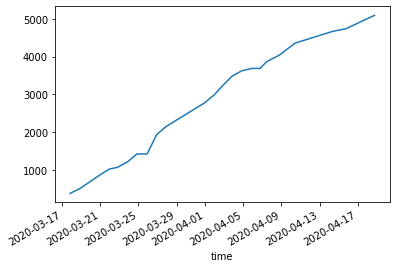

In [0]:
y_train.plot()

In [0]:
fig, s = plt.subplots()
s.scatter(y_train.index, y_train)
preds = xg_reg.predict(X_test)
s.scatter(y_test.index, preds)

In [0]:
gdf['timedays'] = np.arange(gdf.shape[0])
gdf.tail()

cases   lag_1  ...  meanwindow_4  timedays
time                                      ...                        
2020-05-23 18:07:05+00:00   6611  6474.0  ...        -97.25        42
2020-05-27 17:09:06+00:00   6672  6611.0  ...        -97.00        43
2020-05-31 13:14:12+00:00   6799  6672.0  ...       -102.00        44
2020-06-03 09:30:11+00:00   6873  6799.0  ...       -100.00        45
2020-06-05 08:48:13+00:00   6945  6873.0  ...       -101.50        46

[5 rows x 17 columns]

In [0]:
finaltestingday = gdf.loc[:'2020-04-20 23:59:00+00:00'].iloc[-1]['timedays']
gdf.set_index('timedays', inplace=True)

In [0]:
data = gdf.loc[:finaltestingday]
testing = gdf.loc[finaltestingday:]
data.tail()

cases   lag_1   lag_2  ...  meanwindow_3  window_4  meanwindow_4
timedays                         ...                                      
24         4667  4357.0  4038.0  ...   -117.000000   4231.00       -103.00
25         4736  4667.0  4357.0  ...   -223.333333   4449.50       -167.50
26         4971  4736.0  4667.0  ...   -268.333333   4682.75       -245.00
27         5091  4971.0  4736.0  ...   -232.666667   4866.25       -218.50
28         5225  5091.0  4971.0  ...   -204.666667   5005.75       -233.25

[5 rows x 16 columns]

##  we will use the approach of predicting one time step at a time

In [0]:
for _ in range(10): # 10 steps
    data = data.append(pd.Series({'cases':0}), ignore_index=True)
    updata = make_dataframe(data, colname='cases') # create features for current timestep
    x = updata[[c for c in data.columns if not c == 'cases']] # make feature matr
    preds = xg_reg.predict(x) # predict next day
    data.iloc[-1, 0] = preds[-1]
    _ +=1

In [0]:
updata.iloc[-13:]

cases        lag_1  ...     window_4  meanwindow_4
26  4971.000000  4736.000000  ...  4682.750000   -245.000000
27  5091.000000  4971.000000  ...  4866.250000   -218.500000
28  5225.000000  5091.000000  ...  5005.750000   -233.250000
29  4790.474609  5225.000000  ...  5019.368652   -183.500000
30  4666.250977  4790.474609  ...  4943.181396   -139.500000
31  4666.250977  4666.250977  ...  4836.994141    -13.618652
32  4666.250977  4666.250977  ...  4697.306885     76.187256
33  4666.250977  4666.250977  ...  4666.250977    106.187256
34  4666.250977  4666.250977  ...  4666.250977    139.687256
35  4666.250977  4666.250977  ...  4666.250977     31.055908
36  4666.250977  4666.250977  ...  4666.250977      0.000000
37  4666.250977  4666.250977  ...  4666.250977      0.000000
38     0.000000  4666.250977  ...  3499.688232      0.000000

[13 rows x 16 columns]

In [0]:
xg_reg.feature_importances_

array([0.38484442, 0.61515564, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

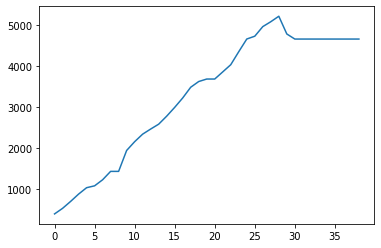

In [0]:
data['cases'].plot()

Text(0, 0.5, 'cases')

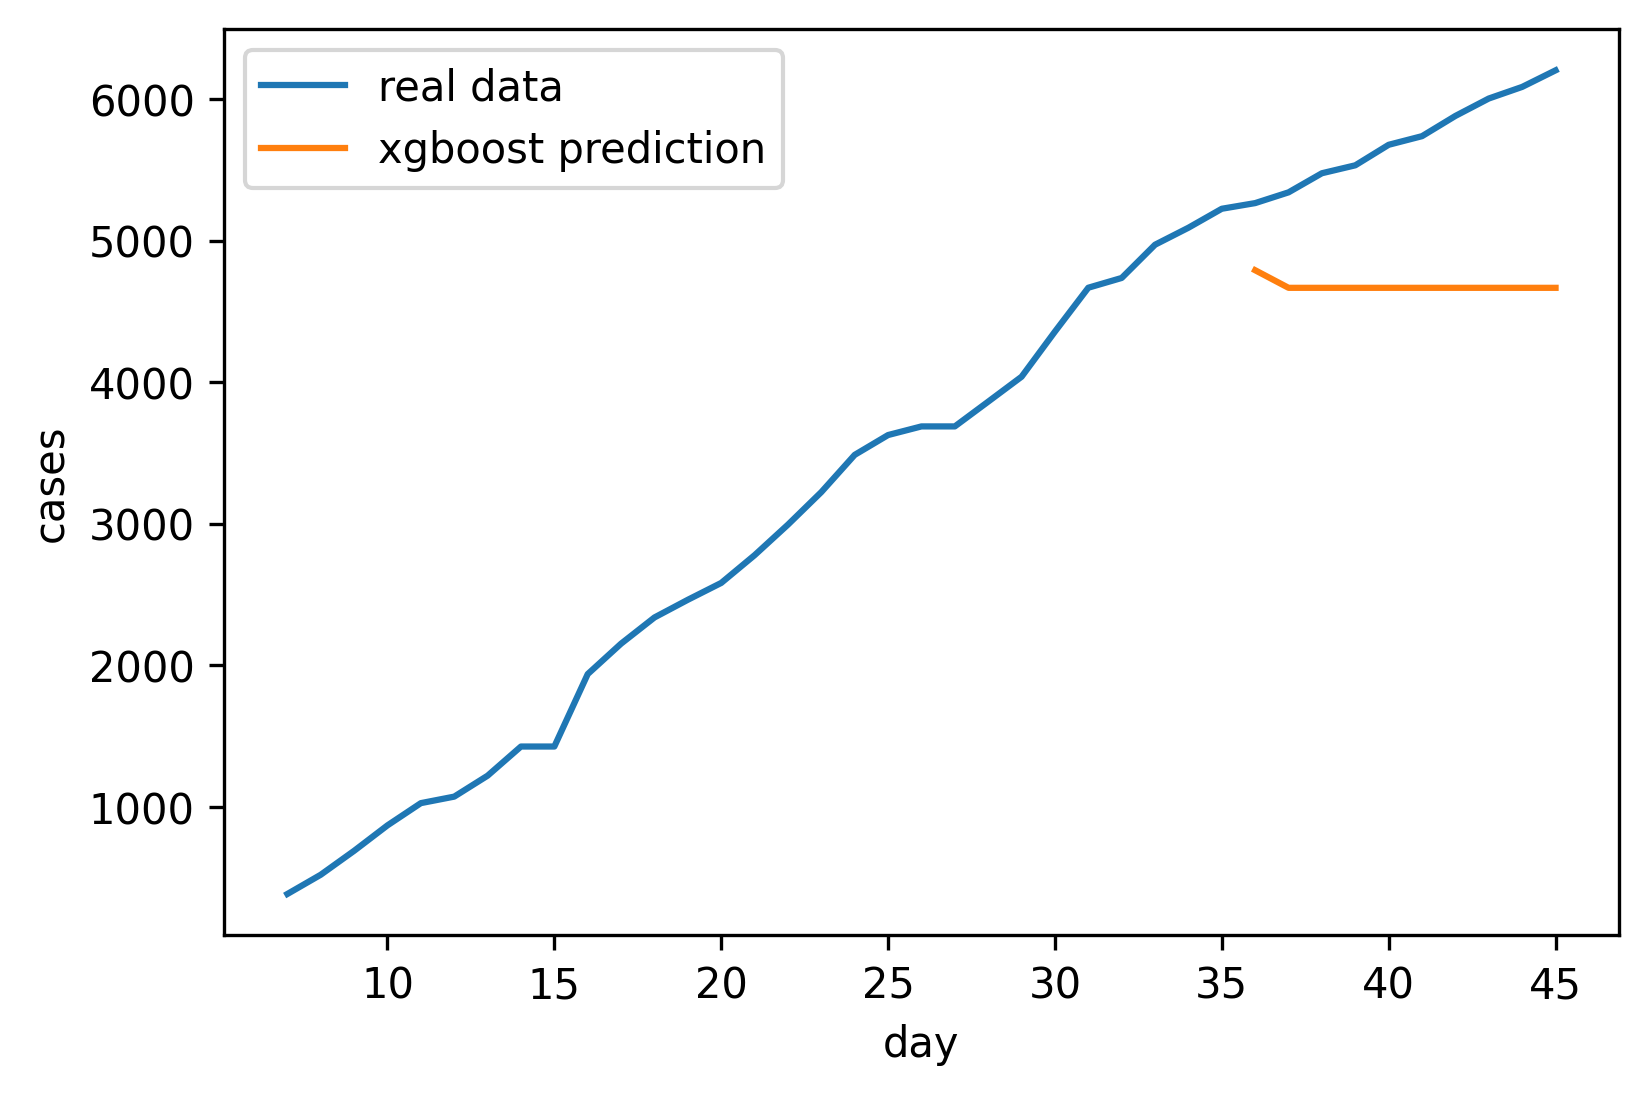

In [0]:
fig, s = plt.subplots(dpi=300)
s.plot(df['timedays'].iloc[7:-8], df['DE-BE_cases'].iloc[7:-8], label='real data')
s.plot((data.index.values+7)[-10:],data['cases'][-10:], label='xgboost prediction')
s.legend()
s.set_xlabel('day')
s.set_ylabel('cases')

In [0]:
d = data['cases'][-10:].values
d

array([4790.47460938, 4666.25097656, 4666.25097656, 4666.25097656,
       4666.25097656, 4666.25097656, 4666.25097656, 4666.25097656,
       4666.25097656, 4666.25097656])

In [0]:
e = df['DE-BE_cases'].iloc[-18:-8].values

In [0]:
rmse = np.sqrt(np.mean((d-e)**2))
rmse

1090.798216508256